## LLM Architecture

GPT stands for generative pre-trained transformer and are large deep networks trained to predict the next word in a sequence. Their architecture consists of a stacked number of transformer blocks which we will implement here.

In order to load the weights of GPT-2 later on, we will use the parameters used for this model.

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # trained on ~50k tokens using BPE tokenizer
    "context_length": 1024,  # the max number of input tokens the model can handle
    "emb_dim": 768,          # the dimension of the embeddings
    "n_heads": 12,           # the number of attention heads
    "n_layers": 12,          # the number of transformer blocks
    "drop_rate": 0.1,        # the dropout rate to prevent overfitting
    "qkv_bias": False        # whether to use bias in the QKV linear layer
}

We will start by implementing a DummyGPTModel class to make it easier to see what else needs implementing.

In [1]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(config)
            for _ in range(config["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(config["emb_dim"])
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        
    def forward(self, x):
        return x


class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        
    def forward(self, x):
        return x

This dummy implementation consists of

- token embeddings
- positional embeddings
- dropout
- transformer blocks
- final layer norm
- linear output head

In the forward method we can see how the input data flows through the various components.

We now start by preparing our input data and initializing a new 124-million parameter Dummy GPT model.

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output logits shape:", logits.shape)
print("Logits:\n", logits)

Output logits shape: torch.Size([2, 4, 50257])
Logits:
 tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer Normalization

Training such deep neural networks can cause vanishing or exploding gradients which makes it difficult to find a set of parameters which minimizes the loss function.

In order to improve the stability, we add `LayerNormalization` to the network. This normalization will make sure that the activations of a layer have a mean of 0 and a variance of 1 and will speed up convergence of the training process.

To illustrate how this works, we go through a toy example of 2 inputs with 5 dimensions and look at the mean and variance before we apply layer normalization.

In [21]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print("Output shape:", out.shape)
print("Output:\n", out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:", mean)
print("Variance:", var)


Output shape: torch.Size([2, 6])
Output:
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Now we apply layer normalization before checking mean and variance

In [22]:
torch.set_printoptions(sci_mode=False)  # Improve readability
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized output:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized output:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Now we are ready to implement a class `LayerNorm`

In [23]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        # unbiased=False means we divide by N instead of N-1
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        out = (x - mean) / torch.sqrt(var + self.eps)
        return out * self.scale + self.shift

Applying it to our test input we find

In [24]:
layer_norm = LayerNorm(emb_dim=5)
out_norm = layer_norm(batch_example)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True, unbiased=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Feed-forward network with GELU activation

We need to implement a small feed-forward network as part of the transformer block. Here, we will start by implementing the GELU activation which is a smooth variant of the ReLU activation.

$$GELU(x) \approx 0.5 \cdot x \cdot \big( 1 + tanh \big[ \sqrt{ \frac{2}{\pi} } \cdot \big( x + 0.044715 \cdot x^3 \big) \big] \big)$$

We implement class `GELU` below.

In [26]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                (x + 0.044715 * torch.pow(x, 3))
            )
        )

Let's plot it to get a better idea of its shape.

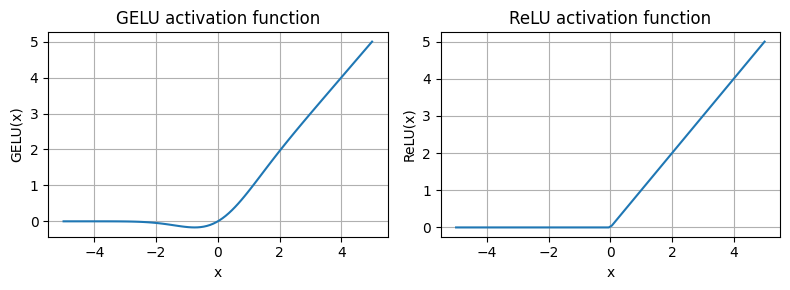

In [29]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-5, 5, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of the GELU function compared to teh ReLU leads to better optimization properties during training which allows for smoother adjustment of the model parameters.

Now we use the GELU function to implement our feed-forward network class.

In [31]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),  # Increase the hidden dimension
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"]),  # Decrease the output dimension
        )
        
    def forward(self, x):
        return self.layers(x)

In [32]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, GPT_CONFIG_124M["emb_dim"])
out = ffn(x)
print("Output shape:", out.shape)

Output shape: torch.Size([2, 3, 768])


### Adding shortcut connections

Shortcut connection are also called skip or residual connections and allow the input activation and the gradient during back-propagation to pass by a layer. Those connections have been introduced to mitigate the vanishing gradient problem and play a crucial part to maintain the gradient during backpropagation.

As an example we implement a example deep network below.

In [33]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Sequential(
                nn.Linear(layer_sizes[i], layer_sizes[i+1]),
                nn.ReLU()
            ))
    
    def forward(self, x):
        for layer in self.layers:
            x_out = layer(x)
            if self.use_shortcut and x.shape == x_out.shape:
                x = x + x_out
            else:
                x = x_out
        return x

Let's test the example network with and without shortcut connections and look at their gradients.

In [38]:
def print_gradient(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


# Initialize the network without shortcut connections
layer_sizes = [3, 3, 3, 3, 3, 1]
use_shortcut = False
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_wo_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut)
print("Without shortcut connections:")
print_gradient(model_wo_shortcut, sample_input)
print()
# Initialize the network with shortcut connections
torch.manual_seed(123)
use_shortcut = True
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut)
print("With shortcut connections:")
print_gradient(model_with_shortcut, sample_input)

Without shortcut connections:
layers.0.0.weight has gradient mean of 0.0006875665276311338
layers.1.0.weight has gradient mean of 0.0019083978841081262
layers.2.0.weight has gradient mean of 0.0038205476012080908
layers.3.0.weight has gradient mean of 0.0038610314950346947
layers.4.0.weight has gradient mean of 0.02481495402753353

With shortcut connections:
layers.0.0.weight has gradient mean of 0.5557742714881897
layers.1.0.weight has gradient mean of 0.09135337918996811
layers.2.0.weight has gradient mean of 0.7913904190063477
layers.3.0.weight has gradient mean of 0.21711303293704987
layers.4.0.weight has gradient mean of 3.140749216079712


### Putting it together in a transformer block

Now that we have implemented the various parts required to create a transformer block, we can create class `TransformerBlock`, using the `MultiHeadAttention` we implemented in Chapter 3.

In [44]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))

from Chapter3.multihead_attention import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            dropout=config["drop_rate"],
            num_heads=config["n_heads"],
            qkv_bias=config["qkv_bias"]
        )
        self.feed_forward = FeedForward(config)
        self.ln1 = LayerNorm(config["emb_dim"])
        self.ln2 = LayerNorm(config["emb_dim"])
        self.drop_shortcut = nn.Dropout(config["drop_rate"])
        
    def forward(self, x):
        # Apply the attention block with shortcut connection
        shortcut = x
        x = self.ln1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Apply the feed-forward network with shortcut connection
        shortcut = x
        x = self.ln2(x)
        x = self.feed_forward(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

Here, we apply layer normalization *before* the two components of the transformer block and dropout after each component (PreLayerNorm). The original implementation of the transformer applied layer normalization *after* self-attention and feed-forward network which often lead to worse training dynamics.

Let's test the transformer block on our sample input. Comparing input and output shape we see that each transformer block does not alter the dimension of the input. This is crucial feature of the architecture which allows its application to many sequence-to-sequence tasks. While the dimension doesn't change, the encoded information in the output context vector does encapsulate the full input sequence. So the output vector is updated with the new contextual information from the entire input sequence.

In [46]:
torch.manual_seed(123)
x = torch.randn(2, 4, GPT_CONFIG_124M["emb_dim"])
transformer_block = TransformerBlock(GPT_CONFIG_124M)
out = transformer_block(x)
print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### The GPT model

We are now ready to put the full GPT model architecture together.

In [47]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])
        
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])]
        )
        self.final_norm = LayerNorm(config["emb_dim"])
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [61]:
torch.manual_seed(123)
gpt_model = GPTModel(GPT_CONFIG_124M)

out = gpt_model(batch)
print("Input batch:\n", batch)
print("Output logits shape:", out.shape)
print("Output logits:\n", out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output logits shape: torch.Size([2, 4, 50257])
Output logits:
 tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


The output shape is `[2, 4, 50257]` as we have 2 input samples with 4 dimensions each. The last dimension corresponds to the vocabulary size of the tokenizer which is `50257`.

We can find the total number of parameters of the model using the `numel()` function.

In [52]:
total_params = sum(p.numel() for p in gpt_model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


The reason the number of parameters is not the expected 124 million of GPT-2 is due to the concept of *weight tying* used in the original GPT-2 implementation. It re-uses the token embedding layer in it's output layer.

If we print the shape of the token embedding layer and remove the parameters of the output layer from the overall parameter count we end up at the expected 124 million of the original GPT-2 model.

In [53]:
print(f"Token embedding layer shape: {gpt_model.tok_emb.weight.shape}")
print(f"Output layer shape: {gpt_model.out_head.weight.shape}")

total_params_gpt2 = (
    total_params - sum(p.numel() for p in gpt_model.out_head.parameters())
)
print(f"Total number of parameters (GPT-2): {total_params_gpt2:,}")

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Total number of parameters (GPT-2): 124,412,160


While weight tying reduces the overall number of parameters and thus the memory footprint of the model, it can also lead to worse training results. For this reason modern LLMs do usually not use weight tying.

Another interesting measure to compute is the memory requirement of the model. We will do this for the version without weight tying.

In [55]:
total_size_bytes = total_params * 4  # Assuming float32 precision
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total memory requirement: {total_size_mb:.2f} MB")

Total memory requirement: 621.83 MB


We are initializing the smallest GPT-2 version here with 163 million parameters with

- a context length of 1024
- an embedding dimension of 768
- 12 attention heads
- 12 transformer blocks

GPT-2 large in comparison consists of

- a context length of 1024
- an embedding dimension of 1280
- 20 attention heads
- 36 transformer blocks

which computes to ~770 million parameters and a memory footprint of ~3GB.

In [59]:
GPT_LARGE_CONFIG = {
    "vocab_size": 50257,     # trained on ~50k tokens using BPE tokenizer
    "context_length": 1024,  # the max number of input tokens the model can handle
    "emb_dim": 1280,         # the dimension of the embeddings
    "n_heads": 20,           # the number of attention heads
    "n_layers": 36,          # the number of transformer blocks
    "drop_rate": 0.1,        # the dropout rate to prevent overfitting
    "qkv_bias": False        # whether to use bias in the QKV linear layer
}

gpt_model_large = GPTModel(GPT_LARGE_CONFIG)
total_params_large = sum(p.numel() for p in gpt_model_large.parameters())
total_params_gpt2_large = (
    total_params_large - sum(p.numel() for p in gpt_model_large.out_head.parameters())
)
print(f"Total number of parameters (GPT-2 large): {total_params_gpt2_large:,}")

total_size_bytes = total_params_gpt2_large * 4  # Assuming float32 precision
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total memory requirement: {total_size_mb:.2f} MB")


Total number of parameters (GPT-2 large): 773,891,840
Total memory requirement: 2952.16 MB


### Generating Text

As a final step we will implement the code required to convert the predicted output tokens to text.

In [60]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        # Subset on the last time step which has the logits of the next predicted token
        logits = logits[:, -1, :]  # [batch_size, vocab_size]
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # Picks the most likely token
        idx = torch.cat((idx, idx_next), dim=1)  # And appends it to the running sequence
        
    return idx       

Given we always pick the most likely next token, this is also called *greedy decoding*. We will implement further sampling techniques to obtain a more variable output in the next chapter.

For the moment, we apply our text generation function to a test context.

In [63]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

# Before we generate text, we set the mnodel into evaluation mode
gpt_model.eval()
out = generate_text_simple(
    gpt_model,
    encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out[0].squeeze().tolist())
print("Decoded text:", decoded_text)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Decoded text: Hello, I am Featureiman Byeswickattribute argue


Given we haven't trained the model, the output is a incoherent sequence of tokens. This will improve once we train our model in the next Chapter.